In [8]:
import torch
import numpy as np
from cryodrgn.source import ImageSource
import os
import pickle
import torch

dat = torch.load("/home/gridsan/jroney/all_projections.pt")
ids_flat = dat['ids'].unsqueeze(-1).expand([-1, 192]).reshape((-1,))
images_flat = dat['images'].view([-1,128,128])
phis_flat = dat['phis'].view(-1)
thetas_flat = dat['thetas'].view(-1)

/tmp/ipykernel_3319061/2262934945.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dat = torch.load("/home/gridsan/jroney/all_projections.pt")


In [9]:
import sys
from cryofinder.resnet.train import ContrastiveModel

model = ContrastiveModel().cuda()
model.load_state_dict({k[6:] : v for k,v in torch.load("/home/gridsan/jroney/cryofinder-training/resnet_v1_20250302_164847/checkpoints/last.ckpt")['state_dict'].items() if k.startswith("model.")})


/tmp/ipykernel_3319061/1914752274.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict({k[6:] : v for k,v in torch.load("/home/gridsan/jroney/cryofinder

<All keys matched successfully>

In [10]:
images_normalized = torch.clamp((images_flat - images_flat.mean(dim=(-1,-2), keepdim=True)) / images_flat.std(dim=(-1,-2), keepdim=True), -5, 15)
print(images_normalized.shape)
print(ids_flat.shape)

torch.Size([723840, 128, 128])
torch.Size([723840])


In [11]:
#compute embeddings from the model for reference images

all_embs = []
bsize = 1000

with torch.no_grad():
    for i in range(0, images_normalized.shape[0], bsize):
        inputs = images_normalized[i:i+bsize].unsqueeze(1).cuda()
        emb = model(inputs)
        all_embs.append(emb)
        print(i)
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [12]:
import torch.nn.functional as F
all_embs = F.normalize(torch.cat(all_embs), p=2, dim=1)


In [13]:
print(all_embs.shape)

torch.Size([723840, 128])


In [19]:
# compute embeddings on the val2025 dataset

from cryodrgn.source import ImageSource
import os
import torch

emds = [x[:-1].lower().replace('-','_') for x in open("/home/gridsan/jroney/val2025_maps.txt",'r').readlines()]
querylist = []
for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/val_2025_dataset/' + e + ".mrcs"):
        querylist.append(ImageSource.from_file('/home/gridsan/jroney/val_2025_dataset/' + e + ".mrcs").images())

querylist = torch.stack(querylist)
querylist_normed = torch.clamp((querylist - querylist.mean(dim=(-1,-2), keepdim=True)) / querylist.std(dim=(-1,-2), keepdim=True), -5, 15)
with torch.no_grad():
    querylist_emb = model(querylist_normed.view([-1,1,128,128]).cuda()).view(querylist.shape[:-2] + (-1,)) 
    querylist_emb = F.normalize(querylist_emb, p=2, dim=-1)
print(querylist_emb.shape)


torch.Size([11, 14, 128])


In [22]:
affinities = (querylist_emb.unsqueeze(-2).cpu() * all_embs.cpu()).sum(dim=-1)
print(affinities.shape)

torch.Size([11, 14, 723840])


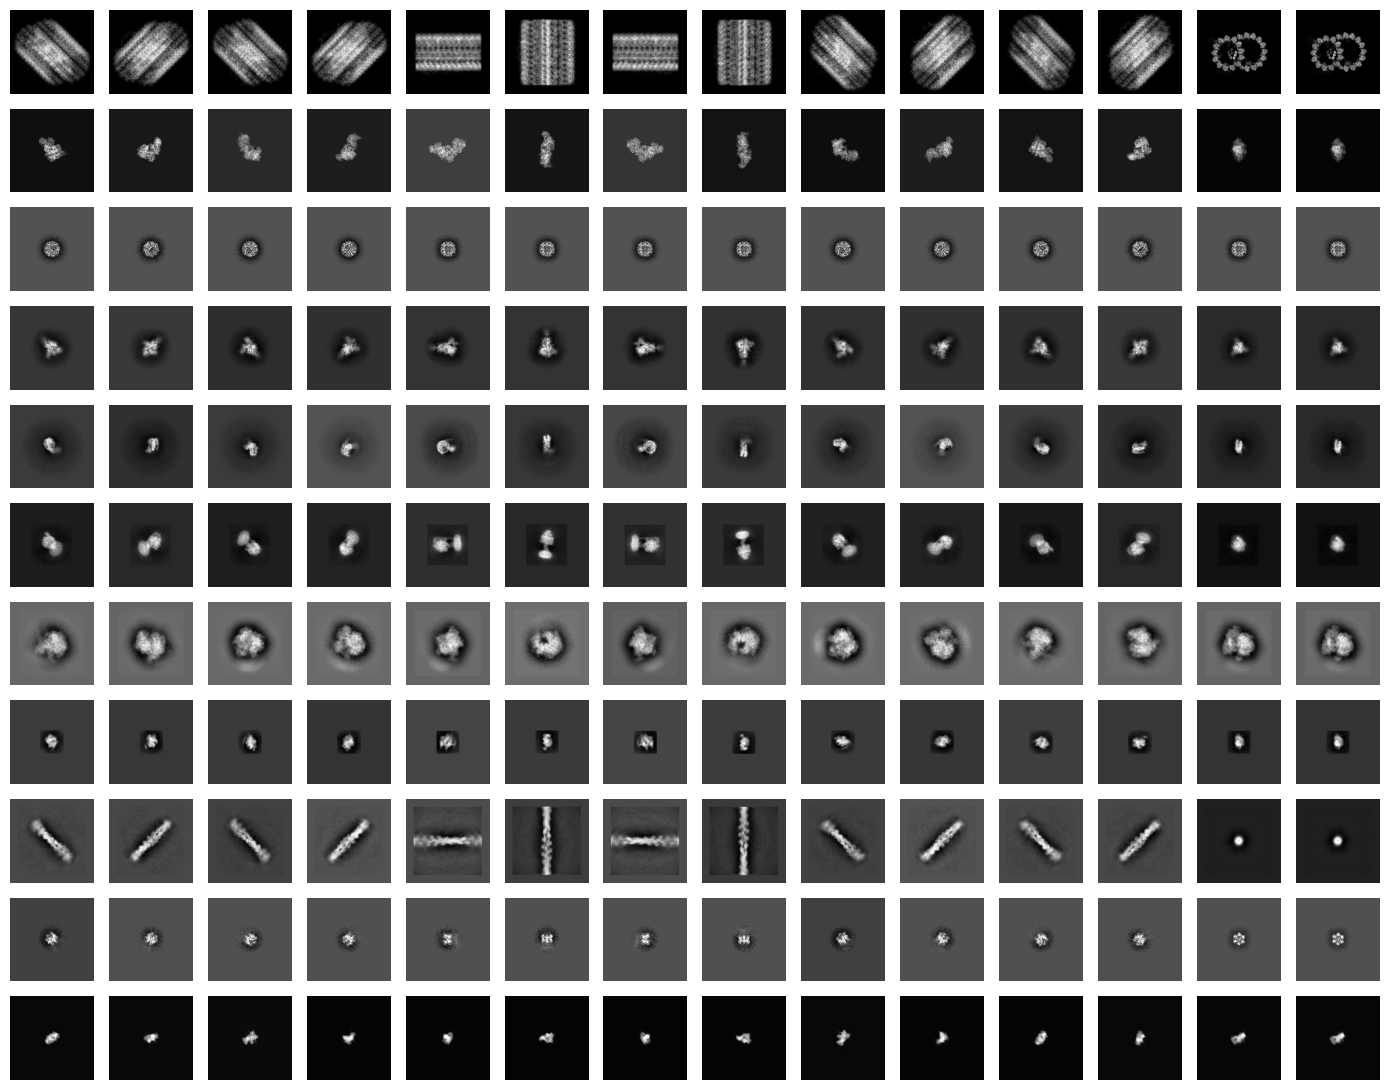

In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_projections(imgs, labels=None, max_imgs=1000, nrows=2):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    ncols = N // nrows

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols, nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        #ax.imshow(img, vmin=-15, vmax=15,cmap="Greys_r")
        ax.imshow(img,cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes


plot_projections(imglist.view([-1,128,128]), nrows=11)
plt.show()

In [4]:
# analyze data from the big run
import pickle 
from analyze_search_outputs import incorporate_postfiltered, score_hits, select_best_maps

# joint_proj_analysis=False
# analyze_refined=True

emds = [x[:-1].lower().replace('-','_') for x in open("../val2025_maps.txt",'r').readlines()]
results = {}
suffix = "_search_res_rot1_trans1_extent0_slowrotate_hartley_postfilternum64_transpf7_numtranspf7_rotpf2.pt"

#suffix = "_search_res_rot1_trans1_extent0_slowrotate_hartley_postfilternum64_transpf7_numtranspf12_rotpf2.pt"

for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/search_results2/' + e + suffix):
        res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cpu')

        for k,v in res.items():
            if k in results:
                results[k].append(v)
            else:
                results[k]  = [v]

results = {k: torch.stack(v) if (torch.is_tensor(v[0]) and k not in  ("unique_indices", "corr_pf")) else v for k,v in results.items()}

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("../emdb_topics.pkl", 'rb')), key=lambda x:x[0])


/tmp/ipykernel_952848/1851757769.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cp

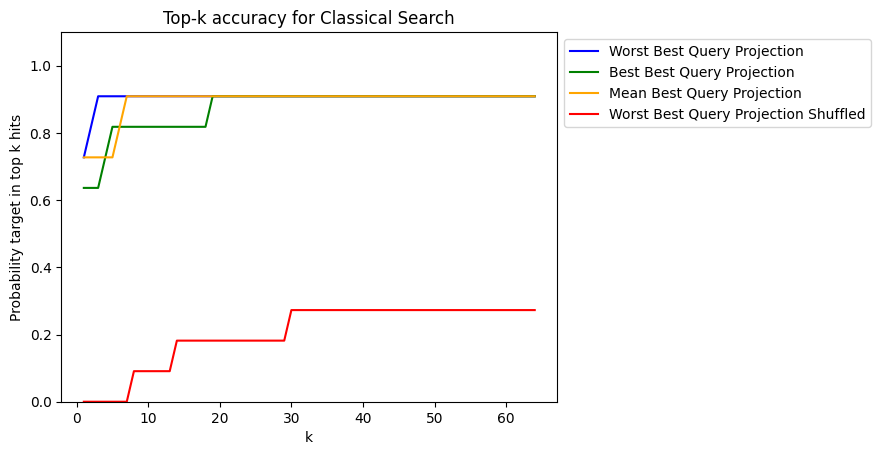

tensor(57.9091)
tensor(55.9091)
tensor(57.1818)


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

maxk = 64

corr_all = incorporate_postfiltered(results, mean_best_projection=True)

bwq_indices = select_best_maps(corr_all, "worst_best")
mbq_indices = select_best_maps(corr_all, "mean_best")
fm_indices = select_best_maps(corr_all, "best_best")


hit_acc_bwq = score_hits(all_topics, bwq_indices, search_terms)
cum_acc_bwq = (hit_acc_bwq.cumsum(dim=-1) > 0).to(torch.float)

def derangement(n):
    perm = torch.randperm(n)
    for i in range(n):
        if perm[i] == i:  # If an element is in its original place, swap it
            perm[i], perm[(i+1) % n] = perm[(i+1) % n], perm[i]
    return perm

hit_acc_bwq_wrong = score_hits(all_topics, bwq_indices[derangement(11)], search_terms)
cum_acc_bwq_wrong = (hit_acc_bwq_wrong.cumsum(dim=-1) > 0).to(torch.float)

hit_acc_fm = score_hits(all_topics, fm_indices, search_terms)
cum_acc_fm = (hit_acc_fm.cumsum(dim=-1) > 0).to(torch.float)

hit_acc_mbq = score_hits(all_topics, mbq_indices, search_terms)
cum_acc_mbq = (hit_acc_mbq.cumsum(dim=-1) > 0).to(torch.float)

plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq.mean(dim=0), color="blue", label="Worst Best Query Projection")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_fm.mean(dim=0), color="green", label="Best Best Query Projection")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_mbq.mean(dim=0), color="orange", label="Mean Best Query Projection")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq_wrong.mean(dim=0), color="red", label="Worst Best Query Projection Shuffled")

plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for Classical Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc_bwq.mean(dim=0).sum(dim=-1))
print(cum_acc_fm.mean(dim=0).sum(dim=-1))
print(cum_acc_mbq.mean(dim=0).sum(dim=-1))

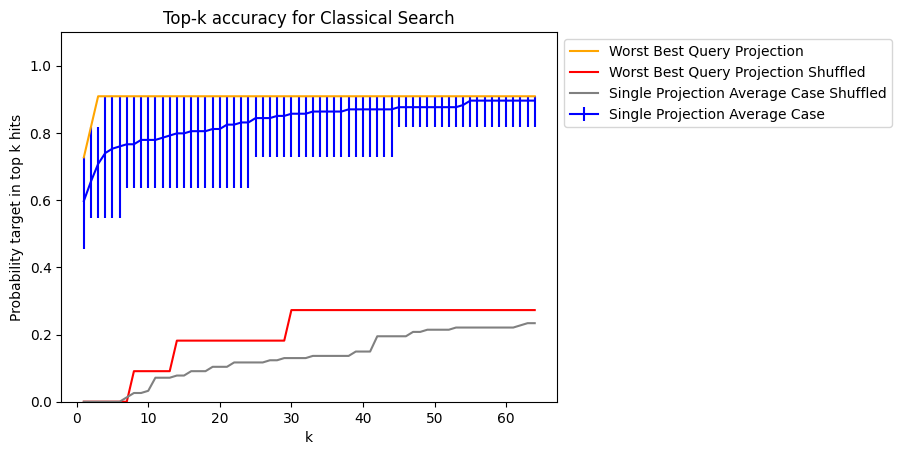

tensor(53.5584)
tensor(57.9091)


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


norm = colors.Normalize(vmin=0, vmax=13)
cmap = cm.viridis 
scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)


maxk = 64

corr_all = incorporate_postfiltered(results, mean_best_projection=False)

hit_indices = corr_all.view([11,14,-1,192]).max(dim=-1)[0].topk(maxk, dim=-1)[1]

hit_acc = score_hits(all_topics, hit_indices, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

hit_acc_wrong = score_hits(all_topics, hit_indices[derangement(11)], search_terms)
cum_acc_wrong = (hit_acc_wrong.cumsum(dim=-1) > 0).to(torch.float)

avg = cum_acc.mean(dim=(0,1))
rand = torch.randint(14, (1000, 11))
dist = torch.stack([cum_acc[torch.arange(11),r].mean(dim=0) for r in rand])


lb = torch.quantile(dist, 0.025, dim=0)  # 2.5th percentile
ub = torch.quantile(dist, 0.975, dim=0)  # 97.5th percentile


plt.errorbar(torch.arange(cum_acc.shape[-1]) + 1, avg, yerr=[avg - lb, ub - avg], color="blue", label=f"Single Projection Average Case")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq.mean(dim=0), color="orange", label="Worst Best Query Projection")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq_wrong.mean(dim=0), color="red", label="Worst Best Query Projection Shuffled")
plt.plot(torch.arange(cum_acc_wrong.shape[-1]) + 1, cum_acc_wrong.mean(dim=(0,1)), color="grey", label="Single Projection Average Case Shuffled")


plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for Classical Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc.mean(dim=(0,1)).sum(dim=-1))
print(cum_acc_bwq.mean(dim=0).sum(dim=-1))


(<Figure size 500x1000 with 50 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, 

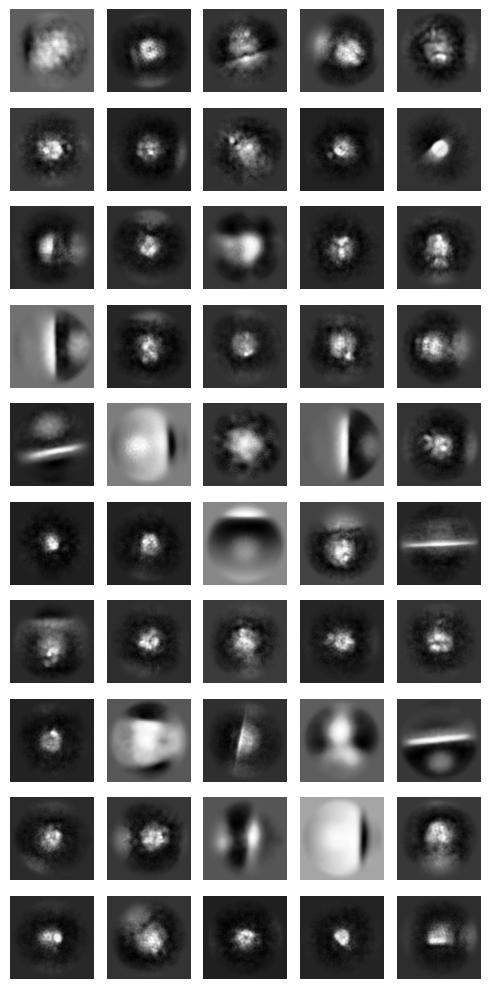

In [79]:
from cryodrgn.source import ImageSource

mira70s = ImageSource.from_file("../test_cases/cryosparc_P230_J164_020_class_averages.mrc").images()
mirajunk1 = ImageSource.from_file("../test_cases/cryosparc_P230_J689_020_class_averages.mrc").images()
mirajunk2 = ImageSource.from_file("../test_cases/cryosparc_P230_J689_020_class_averages.mrc").images()

#plot_projections(mira70s, nrows=10)
plot_projections(mirajunk1, nrows=10)

(<Figure size 700x200 with 14 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >]], dtype=object))

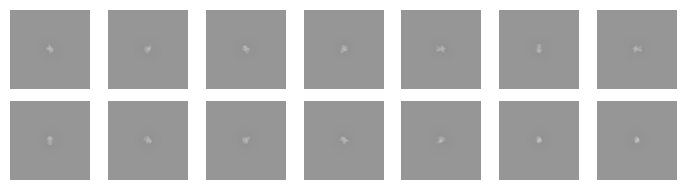

In [7]:
from cryodrgn.source import ImageSource

vos = ImageSource.from_file("../test_cases/cryosparc_P25_J411_008_volume_map.mrcs").images()
plot_projections(vos, nrows=2)

In [61]:
res = torch.load('/home/gridsan/jroney/search_results2/cryosparc_P25_J411_008_volume_map_search_res_rot1_trans1_extent0_slowrotate_hartley_postfilternum64_transpf7_numtranspf7_rotpf2.pt')
res = {k: v.unsqueeze(0) if torch.is_tensor(v) else [v] for k,v in res.items()}

/tmp/ipykernel_952848/4151852646.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/cryosparc_P25_J411_008_volume_map

In [62]:
corr_all = incorporate_postfiltered(res, mean_best_projection=True)[:,:12]
bwq_indices = select_best_maps(corr_all, "worst_best")

In [63]:
matched_proj = corr_all[0][torch.arange(12).unsqueeze(1), bwq_indices].argmax(dim=-1)
matched_images = images_all_raw[bwq_indices, matched_proj]

(2362, "Here's the list of biological entities extracted from the text, following your guidelines:\n\n*   METTL1-WDR4\n*   Lys-tRNA\n*   SAM\n")


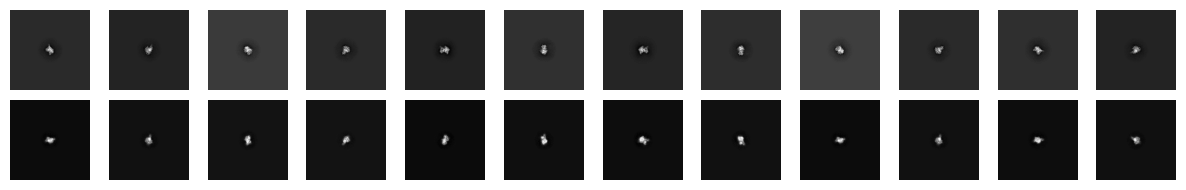

In [85]:
i = 0
plot_projections(torch.cat([vos[:12], matched_images[:,i]]), nrows=2)
print(all_topics[bwq_indices[0,i]])

In [84]:
print("\n----\n".join([all_topics[bwq_indices[0,i]][1] for i in range(64)]))

```json
[
  "GSDMB",
  "IpaH7.8",
  "shigella"
]
```

----
*   SPY
*   GPD-complex
*   GDP-fucose
*   Arabidopsis

----
Here's the list of biological entities extracted from the text, following your guidelines:

*   METTL1-WDR4
*   Lys-tRNA
*   SAM

----
*   EBNA1
*   Dyad Symmetry region
*   EBNA1 DNA binding domain
*   Dyad Symmetry element

----
['pfCSP']

----
Here's the list of biological entities extracted from the input text:

*   Dicer
*   mouse
*   pre-mir-15a
*   Mammalian Dicer
*   pre-miR-15a
----
- AtAgo10-guide RNA complex
- Arabidopsis Ago10-guide RNA complex

----
*   SPY
*   GDP-fucose
*   Arabidopsis SPY

----
```json
[
  "SPY",
  "GDP-fucose",
  "Arabidopsis SPY"
]
```
----
['Cryo-EM structure']

----
Here's the list of biological entities extracted from the text, formatted as requested:

*   nsp12
*   nsp7
*   nsp8
*   RNA
*   Porcine epidemic diarrhea virus

----
- hSERINC3-DeltaICL4-SiA
- Human SERINC3-DeltaICL4

----
- Leucine Rich Repeat Kinase 1
- LRRK1

----
[